# 2. TT model - cijeli notebook

notebook sa samo 10 epoha, ali rezultati su skoro pa podjednaki onima od 50 epoha

### ! importanje potrebnih modula

In [1]:
BATCH_SIZE=32
LR=0.001
DROPOUT=0.2

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
%run helper_notebooks/imports.ipynb #importa sve potrebne module

In [4]:
from data_generator import DataGenerator #generator podataka za trening,validaciju

_____________________________________________________________________________________________________________

# !
###  👽 ukoliko se mijenjala arhitektua TT ali ne i korisnici, izmjeniti naziv modela ovdje

In [5]:
MODEL_VERSION_NAME=str(BATCH_SIZE)+"_"+str(LR) #IZMIJENI ME

🍓 👽 pokreće se zadnja konfiguracija korisnika - može se izmijeniti i zatim -> run all below

In [6]:
%run helper_notebooks/random_walk_version_dropdown.ipynb

interactive(children=(Dropdown(description='verzija korisnika:', options=('6-10-200000-100_ID@_4', '5-8-300000…

In [7]:
VERSION

'6-10-200000-100_ID@_4'

___________________________________________________________________________________________________________

# BIRAJ TT- FASTTEXT ILI TRANSFORMER  (bert)

In [8]:
TRANSFORMER = False # PROMIJENI AKO ŽELIŠ TRANSFORMERA

____

In [9]:
MODEL_VERSION_NAME=MODEL_VERSION_NAME+'@'+datetime.datetime.now().strftime("%m%d-%H%M%S") #extra precaution (:

In [10]:
PATH="datasets/master_generated/"+VERSION+"/"
SAVE_PATH=PATH+'MODELS/'+MODEL_VERSION_NAME+'/'
IDS_PATH=glob.glob(PATH+"tt*Label*")[0]
USER_VECT_PATH = glob.glob(PATH+'*userVect*')[0]
CKPT_PATH=SAVE_PATH+MODEL_VERSION_NAME+"_CKPT" #model checkpoint path

In [11]:
ids_labels_df =pd.read_parquet(IDS_PATH)

In [12]:
ids_labels_df.head(2)

,userID,articleID,label
0,0,53e9a5b6b7602d9702ede2ff,1.0
1,0,53e9aa56b7602d97033c23a5,1.0


In [13]:
try:
    article_vect_dict
except:
    if not TRANSFORMER: #FastText
        article_vect_dict =pd.read_parquet('datasets/dblpv13_fasttext.parquet',  engine='pyarrow').set_index('id').T.to_dict('list') 
        article_vect_dict = {key: np.vstack(value) for key, value in article_vect_dict.items()} # "unpack" vectors
    else: #SenBert transformer
        article_vect_dict_tr_part1 =pd.read_parquet('datasets/mLM_part_1',  engine='pyarrow').set_index('id').T.to_dict('list') 
        article_vect_dict_tr_part1 = {key: np.vstack(value) for key, value in article_vect_dict_tr_part1.items()} # "unpack" vectors
        article_vect_dict_tr_part2 =pd.read_parquet('datasets/mLM_part_2',  engine='pyarrow').set_index('id').T.to_dict('list') 
        article_vect_dict_tr_part2 = {key: np.vstack(value) for key, value in article_vect_dict_tr_part2.items()} # "unpack" vectors
        article_vect_dict = {**article_vect_dict_tr_part1, **article_vect_dict_tr_part2}

In [14]:
input_shape=article_vect_dict['558b49f984ae84d265c28c14'].shape[1]
input_shape

300

In [15]:
user_vect_dict=pd.read_json(USER_VECT_PATH).set_index('userID').T.to_dict('list') 
user_vect_dict = {key: np.vstack(value[int(TRANSFORMER)]) for key, value in user_vect_dict.items()}
#user_vect_dict = {key: np.vstack(value) for key, value in user_vect_dict.items()}

In [16]:

print("Number of users:",len(user_vect_dict),"\nNumber of  articles:", len(article_vect_dict),"\nNumber of user-article-label pairs: ",len(ids_labels_df))

Number of users: 200016 
Number of  articles: 3851441 
Number of user-article-label pairs:  2601174


In [17]:
print("Number of unique articles:",len(set(ids_labels_df['articleID'])))

Number of unique articles: 1591307


In [18]:
def split(X, test_size): #splitting dataset to train, test, validate set
    gs = GroupShuffleSplit(n_splits=10, #num of re-shuffling
                            test_size=test_size,
                            random_state=42,
                            )
    train_ix, test_ix = next(gs.split( X, groups=X['userID'])) #one user in only one dataset (train or test or validate)
    df_train = X.loc[train_ix]
    df_test = X.loc[test_ix]
    
    
    return df_train, df_test
    


In [19]:
def shuffle(x): #shuffle dataset
    idx = np.random.permutation(x.index)
    x = x.reindex(idx)
    x.reset_index(drop=True, inplace=True) #reset indexes     
    return x   
    

In [20]:
df_train, df_test = split(ids_labels_df, 0.2)
df_test.reset_index(drop=True, inplace=True) #reset indexes     
df_test, df_val  = split(df_test, 0.5)

In [21]:
df_train=shuffle(df_train)
df_test=shuffle(df_test)
df_val=shuffle(df_val)

In [22]:
print("size of training set:",len(df_train),"\nsize of validation set:",len(df_val),"\nsize of test set:",len(df_test))

size of training set: 2080404 
size of validation set: 260342 
size of test set: 260428


In [23]:
df_train.head()

,userID,articleID,label
0,103443,53e99867b7602d97020a4052,0.0
1,105800,5db2d1a847c8f7664615f477,0.0
2,162790,55503f0e45ce0a409eb2bf4d,1.0
3,22716,557efd1f6fee0fe990cadec2,0.0
4,63297,53e9acfdb7602d97036d952d,1.0



________________________________________________________________________________________________
mariniranje skupa za trening je gotovo, bacamo se na definiranje fja za treniranje

prve dvije čelije su za learning rate finder

In [27]:

class MultiplicativeLearningRate(keras.callbacks.Callback):
    
    def __init__(self, factor):
        self.factor = factor
        self.losses = []
        self.learning_rates = []
        
    def on_batch_end(self, batch, logs):
        self.learning_rates.append(KB.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        KB.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [28]:

def find_lr(model, input_gen, data_len, batch_size, min_lr = 10**-6, max_lr=10):
    
    # Compute learning rate multiplicative factor
    num_iter = data_len // batch_size
    lr_factor = np.exp(np.log(max_lr / min_lr) / num_iter)
    
    # Train for 1 epoch, starting with minimum learning rate and increase it
    KB.set_value(model.optimizer.lr, min_lr)
    lr_callback = MultiplicativeLearningRate(lr_factor)
    model.fit(input_gen, epochs=1, batch_size=batch_size, callbacks=[lr_callback])
    
    # Plot loss vs log-scaled learning rate
    sns.set(rc={'figure.figsize':(20,10)})
    plot = sns.lineplot(lr_callback.learning_rates, lr_callback.losses)
    plot.set(xscale="log", 
             xlabel="Learning Rate (log-scale)", 
             ylabel="Training Loss")

In [29]:
def cosine_embedding_loss(y_true, y_pred):
    margin= -0.7
    return tf.reduce_mean( y_true * (1. - y_pred) + (1 -y_true) * tf.maximum(0., y_pred - margin))


In [30]:
def accuracy(y_true, y_pred):
    '''compute classification accuracy with a fixed threshold on distances
    '''
    return KB.mean(KB.equal(y_true, KB.cast(y_pred > 0.5, y_true.dtype)))  

In [31]:
# This function keeps the initial learning rate for the first n epochs
# and decreases it exponentially after that.
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [32]:
training_generator =DataGenerator(df_train, article_vect_dict, user_vect_dict,dim=input_shape, batch_size=BATCH_SIZE)
validation_generator = DataGenerator(df_val, article_vect_dict, user_vect_dict, dim=input_shape, batch_size=BATCH_SIZE)
testing_generator = DataGenerator(df_test, article_vect_dict, user_vect_dict,dim=input_shape, batch_size=BATCH_SIZE,shuffle=False)

 #### 🐟 tri čelije ispod se ne koriste ukoliko se koristi tensorboard hparam tuning 

In [33]:
def one_tower():    
    input=layers.Input(input_shape)
    x=layers.BatchNormalization()(input)
    x=layers.Dropout(DROPOUT)(x)
    x=layers.Dense(250)(x)
    x=layers.Activation('relu')(x)

    x=layers.BatchNormalization()(x)
    x=layers.Dropout(DROPOUT)(x)
    x=layers.Dense(200)(x)
    x=layers.Activation('relu')(x)

    x=layers.BatchNormalization()(x)
    x=layers.Dropout(DROPOUT)(x)
    x=layers.Dense(150)(x)
    x=layers.Activation('relu')(x)

    x=layers.BatchNormalization()(x)
    x=layers.Dropout(DROPOUT)(x)
    x=layers.Dense(100)(x)
    x=layers.Activation('relu')(x)
    
    embedding_network = keras.Model(input, x)
    return embedding_network


In [34]:
#cosine
user_input = Input(shape=input_shape)
article_input = Input(shape=input_shape)

shared_tower=one_tower()

user_output=shared_tower(user_input)
article_output=shared_tower(article_input)

dot=tf.keras.layers.Dot(axes=(1, 1),normalize=True)([user_output, article_output])  

prediction = tf.keras.layers.Dense(1, activation="sigmoid")(dot)

In [35]:
opt = keras.optimizers.Adam(learning_rate=LR)


model = Model([user_input, article_input], prediction)


#loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),


model.compile(optimizer=opt,
              loss=cosine_embedding_loss,
              metrics=accuracy,
              run_eagerly=False)

In [36]:
#model.summary()

In [37]:
#tf.keras.utils.plot_model(model)

In [38]:
#optimal learning rate
# ! trening modela 

#find_lr(model, training_generator, len(df_train), batch_size=BATCH_SIZE) 

In [39]:
#STOP

___

🍓 brisanje logova - TensorBoard

In [40]:
#%reload_ext tensorboard

____

In [41]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, #train i val acc&loss
                                                      histogram_freq=4,
                                                      profile_batch=0) # ovo uklanja ružnjikave ispise tokom fit metode



stopper_callback = tf.keras.callbacks.EarlyStopping(  
                       monitor='loss', 
                       patience=15,
                       min_delta=0.005, 
                       restore_best_weights=True                   
                       ) 




lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)







#ckpt_callback = tf.keras.callbacks.ModelCheckpoint( # ¬lijepi ispisi
#                                      CKPT_PATH,
#                                      monitor='val_loss',
#                                      mode='auto',
#                                      save_weights_only=False,
#                                      save_best_only=False,
#                                      save_freq=30) 


In [42]:
#%tensorboard --logdir logs/fit

In [43]:
history=model.fit(training_generator,
          validation_data=validation_generator,
          callbacks=[tensorboard_callback,  # log metrics
                     lr_callback,
                 #    hp.KerasCallback(logdir, hparams),  # log hparams
                     stopper_callback
                    ],
                    #ckpt_callback],     
          epochs=10
          )

Epoch 1/10
65012/65012 [==============================] - 104s 2ms/step - loss: 0.4798 - accuracy: 0.8118 - val_loss: 0.4185 - val_accuracy: 0.8578
Epoch 2/10
65012/65012 [==============================] - 103s 2ms/step - loss: 0.4332 - accuracy: 0.8442 - val_loss: 0.4071 - val_accuracy: 0.8675
Epoch 3/10
65012/65012 [==============================] - 103s 2ms/step - loss: 0.4249 - accuracy: 0.8508 - val_loss: 0.4032 - val_accuracy: 0.8701
Epoch 4/10
65012/65012 [==============================] - 103s 2ms/step - loss: 0.4204 - accuracy: 0.8544 - val_loss: 0.4000 - val_accuracy: 0.8727
Epoch 5/10
65012/65012 [==============================] - 101s 2ms/step - loss: 0.4173 - accuracy: 0.8568 - val_loss: 0.3977 - val_accuracy: 0.8748
Epoch 6/10
65012/65012 [==============================] - 101s 2ms/step - loss: 0.4151 - accuracy: 0.8587 - val_loss: 0.3965 - val_accuracy: 0.8752
Epoch 7/10
65012/65012 [==============================] - 101s 2ms/step - loss: 0.4135 - accuracy: 0.8600 - val_

#### evaluacija modela  

In [44]:
model.evaluate(testing_generator)

8138/8138 [==============================] - 6s 682us/step - loss: 0.3933 - accuracy: 0.8777


[0.3933088481426239, 0.8776879906654358]

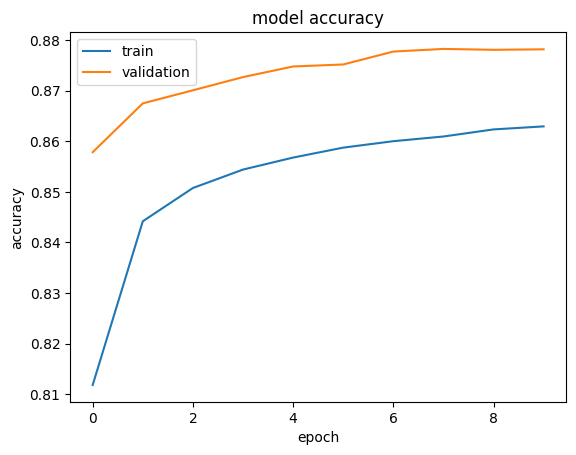

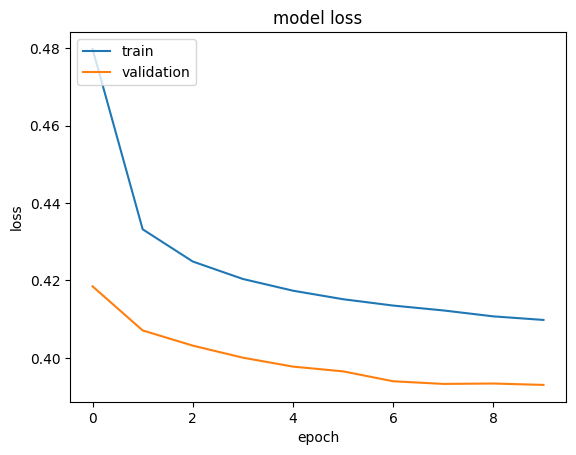

In [45]:
plt.style.use('default')
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 🎣

In [46]:
#user_model= tf.keras.models.load_model(PATH+'MODELS/userTower_v4.h5',compile=False)
#article_model= tf.keras.models.load_model(PATH+'MODELS/itemTower_v4.h5',compile=False)
#model= tf.keras.models.load_model(PATH+'MODELS/twoTower_vf.h5',compile=False)

### Confusion matrix, roc auc, f1


In [47]:
labels = []
preds = []
for step in range(len(testing_generator)):
    data, label = testing_generator.__getitem__(step)
    pred = model.predict(data)
    preds.extend(pred)
    labels.extend(label)

preds=np.vstack(preds)
labels=np.vstack(labels)
y_pred=(preds>=0.5).squeeze()

In [48]:
confusion_matrix(labels, y_pred)


array([[118583,  21423],
       [ 10429, 109981]])

<AxesSubplot:>

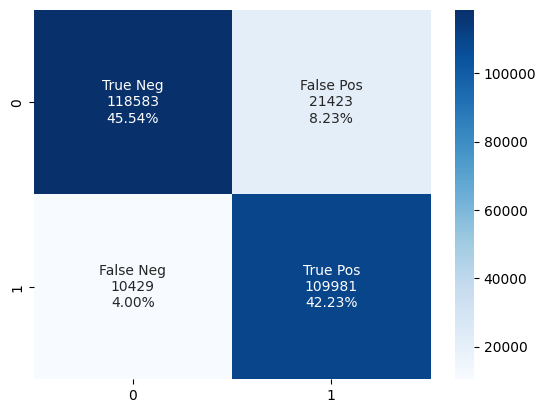

In [49]:
import seaborn as sns

cf_matrix=confusion_matrix(labels, y_pred)




group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels_ = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels_ = np.asarray(labels_).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels_, fmt='', cmap='Blues')

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, y_pred)

0.8776880068812977

In [51]:
roc_auc_score(labels, y_pred)

0.8801863608007033

In [52]:
f1_score(labels, y_pred, average='macro')

0.8775544068043449

In [53]:
f1_score(labels, y_pred, average='micro')

0.8776880068812977

## 3.  Testiranje da li su se pozitivni približili i negativni udaljili

In [54]:
user_tower=article_tower=shared_tower

In [55]:
%run helper_notebooks/repulsion_test.ipynb

sličnost vektora najbolje preporuke sa vektorom korisnika 0.99999994
sličnost vektora najgore preporuke sa vektorom korisnika 0.00812069
model je ispravan


In [56]:
MODEL_VERSION_NAME

'32_0.001@0620-215034'

In [57]:
SAVE_PATH+'twoTower_'+MODEL_VERSION_NAME+'.h5'

'datasets/master_generated/6-10-200000-100_ID@_4/MODELS/32_0.001@0620-215034/twoTower_32_0.001@0620-215034.h5'

## 4. Metrika twitter korisnika

model iz sesije
avg user cossim median for positive example [MODEL]:  0.71195704
avg user cossim median for positive example:  0.8464518
avg user cossim median for negative example [MODEL]:  0.18118425
avg user cossim median for negative example:  0.72791606


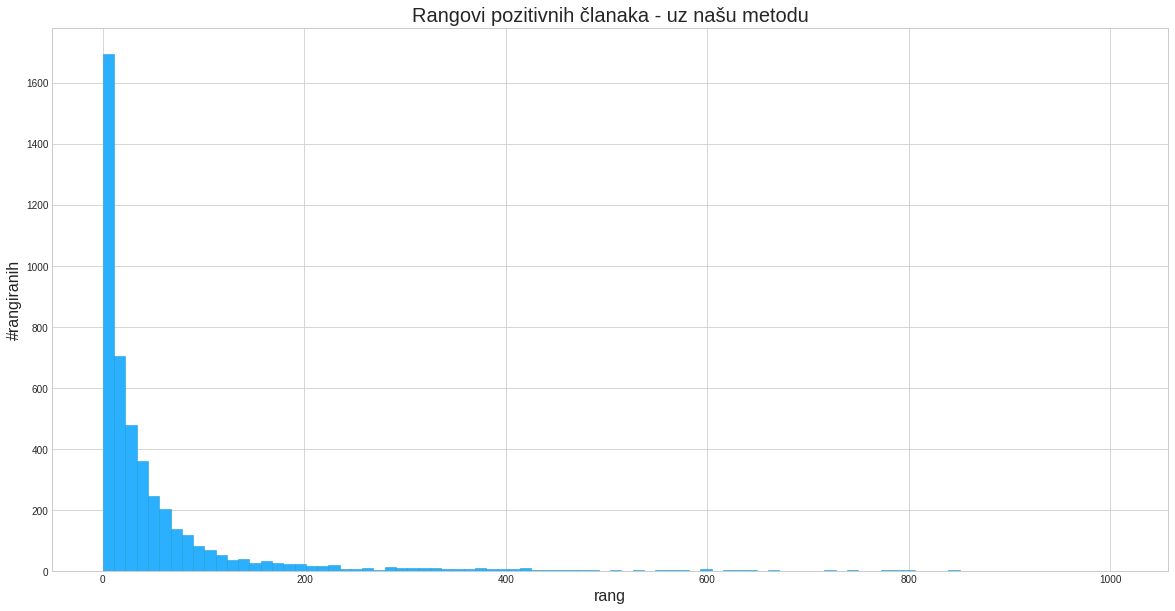

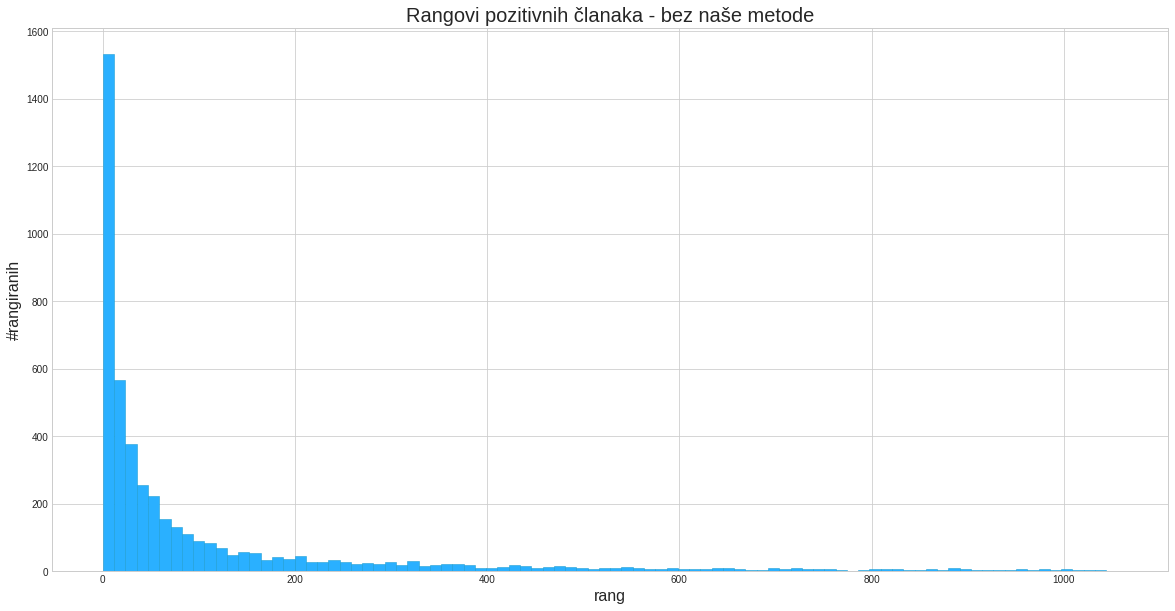

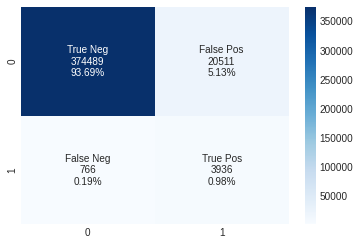

sveukupno imamo 4702 pozitivnih članaka i 413 korisnika
prepoznato 83.70905997447895% pozitivnih članaka
ACC: 0.9467678420423216
roc-auc: 0.8925820087331542
F1 - macro: 0.6212187014723745
F1 - micro: 0.9467678420423216
P@k; k=1
model-mean for all users: 0.6177215189873417
non-model-mean for all users: 0.6379746835443038
P@k; k=3
model-mean for all users: 0.5379746835443038
non-model-mean for all users: 0.5451476793248945

nDCG:
model-mean for all users: 0.712788223362424
non-model-mean for all users: 0.6848975678394907
395
>>>>>>>>>>>> delta rank 1=  -0.020253164556962022


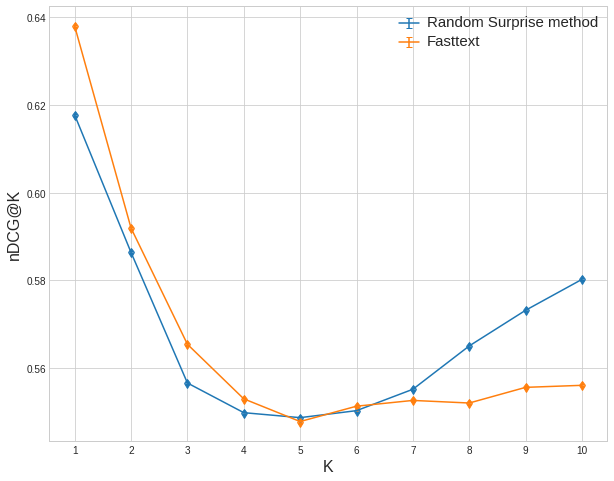

In [58]:
%run helper_notebooks/twitter_ranking.ipynb

In [59]:
%notify

<IPython.core.display.Javascript object>

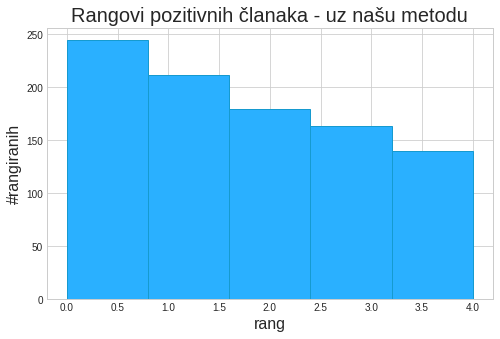

In [60]:
ranks = [r for sublist in user_ranks_m for r in sublist if r < 5] #svi korisnici 

plt.figure(figsize=(8,5)) 
plt.style.use('seaborn-whitegrid') 
plt.hist(ranks, bins=5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=1)
plt.title('Rangovi pozitivnih članaka - uz našu metodu',fontsize=20) 
plt.xlabel('rang',fontsize=16) 
plt.ylabel('#rangiranih',fontsize=16) 
plt.show()

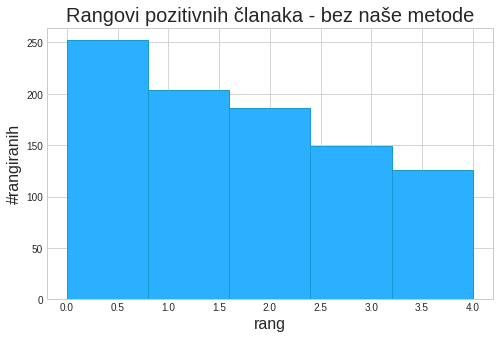

In [61]:
ranks = [r for sublist in user_ranks_p for r in sublist if r < 5] #svi korisnici 

plt.figure(figsize=(8,5)) 
plt.style.use('seaborn-whitegrid') 
plt.hist(ranks, bins=5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=1)
plt.title('Rangovi pozitivnih članaka - bez naše metode',fontsize=20) 
plt.xlabel('rang',fontsize=16) 
plt.ylabel('#rangiranih',fontsize=16) 
plt.show()

## Metrika Andrejevog dataseta - ACC

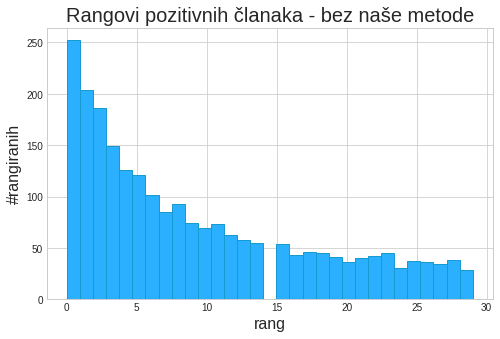

In [62]:
ranks = [r for sublist in user_ranks_p for r in sublist if r < 30] #svi korisnici 

plt.figure(figsize=(8,5)) 
plt.style.use('seaborn-whitegrid') 
plt.hist(ranks, bins=31, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=1)
plt.title('Rangovi pozitivnih članaka - bez naše metode',fontsize=20) 
plt.xlabel('rang',fontsize=16) 
plt.ylabel('#rangiranih',fontsize=16) 
plt.show()

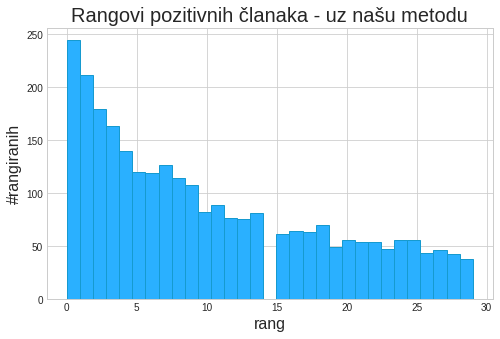

In [63]:
ranks = [r for sublist in user_ranks_m for r in sublist if r < 30] #svi korisnici 

plt.figure(figsize=(8,5)) 
plt.style.use('seaborn-whitegrid') 
plt.hist(ranks, bins=31, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=1)
plt.title('Rangovi pozitivnih članaka - uz našu metodu',fontsize=20) 
plt.xlabel('rang',fontsize=16) 
plt.ylabel('#rangiranih',fontsize=16) 
plt.show()

____________